In [7]:
import os
import glob
import numpy as np
import pandas as pd
import pyhepmc as hep

class MassRecoFromLHE:
    def __init__(self, lhe_path):
        self.lhe_path = lhe_path
        self.on_shell_count = 0
        self.off_shell_count = 0

    def _invariant_mass(self, p1, p2):
        E = p1["E"] + p2["E"]
        px = p1["px"] + p2["px"]
        py = p1["py"] + p2["py"]
        pz = p1["pz"] + p2["pz"]
        return np.sqrt(max(E**2 - px**2 - py**2 - pz**2, 0))

    def _get_four_vector(self, momentum):
        px, py, pz, E = momentum
        return {"px": px, "py": py, "pz": pz, "E": E}

    def Run(self):
        input_file = hep.open(self.lhe_path)
        for i, event in enumerate(input_file):
            found_W = False
            W_mass = None
            N_particle = None
            tau_particle = None

            for p in event.particles:
                if p.pid == 34:
                    found_W = True

                if p.pid == 9900016:  # N
                    N_particle = self._get_four_vector(p.momentum)
                if abs(p.pid) == 15:  # tau
                    tau_particle = self._get_four_vector(p.momentum)

            if found_W:
                self.on_shell_count += 1
            elif N_particle and tau_particle:
                self.off_shell_count += 1
            else:
                print(f"❌ Warning: Event {i} has no W' and incomplete N-tau pair!")

        input_file.close()

# --- 작업 디렉토리 설정 ---
base_dir = "/data6/Users/snuintern1/fork_gen_999/submit_files/condorfiles/LO999"
output_csv_path = "./mass_reco_summary_counts.csv"

# --- 전체 결과 저장용 리스트 ---
summary_records = []

# --- 전체 LHE 파일 탐색 ---
lhe_files = glob.glob(f"{base_dir}/result_WR1000_N*/cmsgrid_final.lhe")
print(f"총 {len(lhe_files)}개 파일 발견됨.")

for lhe_path in lhe_files:
    try:
        # --- 폴더 이름 parsing ---
        folder_name = os.path.basename(os.path.dirname(lhe_path))
        parts = folder_name.replace("result_", "").split("_")
        WR_mass = int(parts[0].replace("WR", ""))
        N_mass = int(parts[1].replace("N", ""))

        label = f"WR{WR_mass}_N{N_mass}"

        print(f"🔍 처리 중: {label}")

        # --- mass reco 수행 ---
        reco = MassRecoFromLHE(lhe_path)
        reco.Run()

        # --- 결과를 리스트에 저장 ---
        summary_records.append({
            "WR_mass": WR_mass,
            "N_mass": N_mass,
            "on_shell_count": reco.on_shell_count,
            "off_shell_count": reco.off_shell_count
        })

    except Exception as e:
        print(f"❌ 에러 발생 ({lhe_path}): {e}")

# --- 최종 전체 summary를 CSV로 저장 ---
df_summary = pd.DataFrame(summary_records)
df_summary.to_csv(output_csv_path, index=False)
print(f"\n✅ 최종 summary CSV 저장 완료: {output_csv_path}")

총 9개 파일 발견됨.
🔍 처리 중: WR1000_N200
🔍 처리 중: WR1000_N600
🔍 처리 중: WR1000_N500
🔍 처리 중: WR1000_N900
🔍 처리 중: WR1000_N300
🔍 처리 중: WR1000_N400
🔍 처리 중: WR1000_N700
🔍 처리 중: WR1000_N800
🔍 처리 중: WR1000_N100

✅ 최종 summary CSV 저장 완료: ./mass_reco_summary_counts.csv


On-shell 이벤트 수: 1869
Off-shell 이벤트 수: 3131


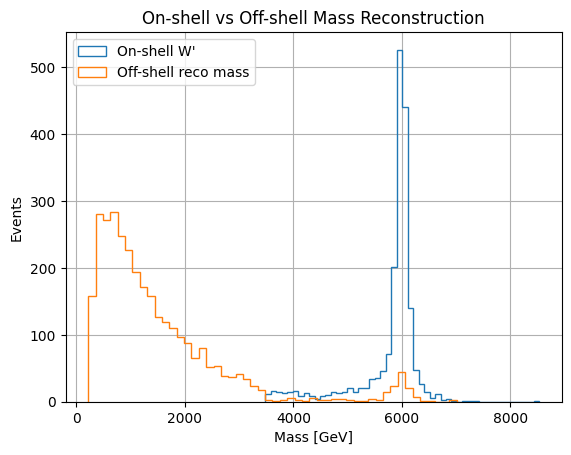

In [6]:
import pyhepmc as hep
import numpy as np

class MassRecoFromLHE:
    def __init__(self, lhe_path):
        self.input = hep.open(lhe_path)
        self.on_shell_masses = []
        self.off_shell_masses = []

    def _invariant_mass(self, p1, p2):
        E = p1["E"] + p2["E"]
        px = p1["px"] + p2["px"]
        py = p1["py"] + p2["py"]
        pz = p1["pz"] + p2["pz"]
        return np.sqrt(max(E**2 - px**2 - py**2 - pz**2, 0))

    def _get_four_vector(self, momentum):
        px, py, pz, E = momentum
        return {"px": px, "py": py, "pz": pz, "E": E}

    def Run(self):
        for i, event in enumerate(self.input):
            found_W = False
            W_mass = None
            N_particle = None
            tau_particle = None

            for p in event.particles:
                if p.pid == 34:
                    found_W = True
                    W_mass = np.sqrt(max(p.momentum[3]**2 - (p.momentum[0]**2 + p.momentum[1]**2 + p.momentum[2]**2), 0))

                if p.pid == 9900016:  # N
                    N_particle = self._get_four_vector(p.momentum)
                if abs(p.pid) == 15:  # tau or anti-tau
                    tau_particle = self._get_four_vector(p.momentum)

            if found_W and W_mass is not None:
                self.on_shell_masses.append(W_mass)
            elif N_particle and tau_particle:
                reco_mass = self._invariant_mass(N_particle, tau_particle)
                self.off_shell_masses.append(reco_mass)
            else:
                # 예외 처리: N, tau 둘 다 없거나 이상한 경우
                print(f"❌ Warning: Event {i} is neither on-shell nor proper off-shell!")

        self.input.close()

# ===== 사용 예시 =====

lhe_file = "/data6/Users/snuintern1/fork_gen_999/submit_files/condorfiles/LO999/result_WR6000_N200/cmsgrid_final.lhe"
mass_reco = MassRecoFromLHE(lhe_file)
mass_reco.Run()

print(f"On-shell 이벤트 수: {len(mass_reco.on_shell_masses)}")
print(f"Off-shell 이벤트 수: {len(mass_reco.off_shell_masses)}")

# mass 리스트 접근
on_shell_masses = mass_reco.on_shell_masses
off_shell_masses = mass_reco.off_shell_masses

# 예시: histogram 그리기
import matplotlib.pyplot as plt

plt.hist(on_shell_masses, bins=50, histtype='step', label="On-shell W'")
plt.hist(off_shell_masses, bins=50, histtype='step', label="Off-shell reco mass")
plt.xlabel("Mass [GeV]")
plt.ylabel("Events")
plt.legend()
plt.grid(True)
plt.title("On-shell vs Off-shell Mass Reconstruction")
plt.show()

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyhepmc as hep

class MassRecoFromLHE:
    def __init__(self, lhe_path):
        self.lhe_path = lhe_path
        self.on_shell_masses = []
        self.off_shell_masses = []
        self.on_shell_count = 0
        self.off_shell_count = 0

    def _invariant_mass(self, p1, p2):
        E = p1["E"] + p2["E"]
        px = p1["px"] + p2["px"]
        py = p1["py"] + p2["py"]
        pz = p1["pz"] + p2["pz"]
        return np.sqrt(max(E**2 - px**2 - py**2 - pz**2, 0))

    def _get_four_vector(self, momentum):
        px, py, pz, E = momentum
        return {"px": px, "py": py, "pz": pz, "E": E}

    def Run(self):
        input_file = hep.open(self.lhe_path)
        for i, event in enumerate(input_file):
            found_W = False
            W_mass = None
            N_particle = None
            tau_particle = None

            for p in event.particles:
                if p.pid == 34:
                    found_W = True
                    W_mass = np.sqrt(max(p.momentum[3]**2 - (p.momentum[0]**2 + p.momentum[1]**2 + p.momentum[2]**2), 0))

                if p.pid == 9900016:  # N
                    N_particle = self._get_four_vector(p.momentum)
                if abs(p.pid) == 15:  # tau
                    tau_particle = self._get_four_vector(p.momentum)

            if found_W and W_mass is not None:
                self.on_shell_count += 1
                self.on_shell_masses.append(W_mass)
            elif N_particle and tau_particle:
                self.off_shell_count += 1
                reco_mass = self._invariant_mass(N_particle, tau_particle)
                self.off_shell_masses.append(reco_mass)
            else:
                print(f"❌ Warning: Event {i} has no W' or incomplete N-tau pair!")

        input_file.close()

# --- 작업 디렉토리 설정 ---
base_dir = "/data6/Users/snuintern1/fork_gen_999/submit_files/condorfiles/LO999"
output_csv_path = "./mass_reco_summary_counts.csv"
output_plot_dir = "./mass_reco_plots"

os.makedirs(output_plot_dir, exist_ok=True)

# --- 전체 결과 저장용 리스트 ---
summary_records = []

# --- 전체 LHE 파일 탐색 ---
lhe_files = glob.glob(f"{base_dir}/result_WR1000_N100/cmsgrid_final.lhe")
print(f"총 {len(lhe_files)}개 파일 발견됨.")

for lhe_path in lhe_files:
    try:
        # --- 폴더 이름 parsing ---
        folder_name = os.path.basename(os.path.dirname(lhe_path))
        parts = folder_name.replace("result_", "").split("_")
        WR_mass = int(parts[0].replace("WR", ""))
        N_mass = int(parts[1].replace("N", ""))

        label = f"WR{WR_mass}_N{N_mass}"

        print(f"🔍 처리 중: {label}")

        # --- mass reco 수행 ---
        reco = MassRecoFromLHE(lhe_path)
        reco.Run()

        # --- CSV용 summary 기록 ---
        if reco.on_shell_masses:
            percentile_99 = np.percentile(reco.on_shell_masses, 1)  
            offshell_below99 = sum(m < percentile_99 for m in reco.off_shell_masses)  
        else:
            percentile_99 = None
            offshell_below99 = 0

        summary_records.append({
        "WR_mass": WR_mass,
        "N_mass": N_mass,
        "on_shell_count": reco.on_shell_count,
        "off_shell_count": reco.off_shell_count,
        "offshell_below99_count": offshell_below99  
})


        # --- 히스토그램 저장 ---
        plt.figure(figsize=(8,6))
        if reco.on_shell_masses:
            plt.hist(reco.on_shell_masses, bins=50, histtype='step', label="On-shell W'", linewidth=1.5)
        if reco.off_shell_masses:
            plt.hist(reco.off_shell_masses, bins=50, histtype='step', label="Off-shell reco mass", linewidth=1.5)
        plt.xlabel("Mass [GeV]")
        plt.ylabel("Events")
        plt.title(f"Mass Reconstruction: {label}")
        plt.grid(True)
        plt.legend()
        plot_path = os.path.join(output_plot_dir, f"{label}.png")
        plt.savefig(plot_path)
        plt.close()
        print(f"🖼️ 그림 저장 완료: {plot_path}")

    except Exception as e:
        print(f"❌ 에러 발생 ({lhe_path}): {e}")

# --- 최종 summary를 CSV로 저장 ---
df_summary = pd.DataFrame(summary_records)
df_summary.to_csv(output_csv_path, index=False)
print(f"\n✅ 최종 summary CSV 저장 완료: {output_csv_path}")

총 1개 파일 발견됨.
🔍 처리 중: WR1000_N100
🖼️ 그림 저장 완료: ./mass_reco_plots/WR1000_N100.png

✅ 최종 summary CSV 저장 완료: ./mass_reco_summary_counts.csv
